# Bachelor Thesis: Pairs Trading

In [1]:
import polars as pl
import duckdb

from datetime import date

## Data Preparation

* Price data is in wide format: date, ticker1, ticker2, ...
* Transform it to long format and cleanup ticker names: ticker, date, price

In [2]:
input_data_base_path = "../data"
output_base_path = ""
duckdb_path = "../db/research.duckdb"


research_period_start = date(2005,1,1)
research_period_end = date(2022,7, 5)

In [3]:
meta_csv_path = f"{input_data_base_path}/SPX_MID_Constituens.csv"

# --------------------------------------------------
# 1. Load metadata with Polars
# --------------------------------------------------
meta_columns = pl.read_csv(meta_csv_path, n_rows=0).columns
meta_schema = {c: pl.Utf8 for c in meta_columns}

df_meta_data = pl.read_csv(
    meta_csv_path,
    schema=meta_schema
)

df_meta_data = df_meta_data.filter(
    pl.col("Sec Type") == "Common Stock"
)

df_meta_data = df_meta_data.with_columns(
    pl.col("Ticker").str.split(" ").list.first().alias("Ticker")
)

# --------------------------------------------------
# 2. Persist metadata to DuckDB
# --------------------------------------------------
con = duckdb.connect(duckdb_path)

# overwrite if table already exists
con.execute("DROP TABLE IF EXISTS metadata")

con.register("metadata_pl", df_meta_data)

con.execute("""
    CREATE TABLE metadata AS
    SELECT * FROM metadata_pl
""")

con.close()

print("✅ Loaded metadata CSV with Polars")
print("✅ Saved metadata table to DuckDB")


✅ Loaded metadata CSV with Polars
✅ Saved metadata table to DuckDB


In [4]:
csv_path = f"{input_data_base_path}/SPX_MID_1990-2022.csv"

# --------------------------------------------------
# 1. Load CSV with Polars (wide format)
# --------------------------------------------------
price_columns = pl.read_csv(csv_path, n_rows=0).columns
price_schema = {
    price_columns[0]: pl.Date,
    **{c: pl.Float64 for c in price_columns[1:]}
}

df_price_wide = pl.read_csv(
    csv_path,
    schema=price_schema,
    try_parse_dates=True
).rename({price_columns[0]: "date"})

df_price_wide = df_price_wide.filter(
    (pl.col("date") >= research_period_start) & 
    (pl.col("date") <= research_period_end)
)

# --------------------------------------------------
# 2. Clean ticker names (remove suffix like " US Equity")
# --------------------------------------------------
clean_columns = {
    c: c.split(" ")[0] for c in df_price_wide.columns if c != "date"
}

df_price_wide = df_price_wide.rename(clean_columns)

valid_tickers = set(df_meta_data["Ticker"].to_list())
cols_to_keep = ["date"] + [col for col in df_price_wide.columns if col != "date" and col in valid_tickers]
df_price_wide = df_price_wide.select(cols_to_keep)

# --------------------------------------------------
# 3. Create long-format version
# --------------------------------------------------
df_price_long = (
    df_price_wide
    .unpivot(
        index="date",
        variable_name="ticker",
        value_name="price"
    )
    .drop_nulls(subset=["price"])
)

# --------------------------------------------------
# 4. Persist both versions to DuckDB
# --------------------------------------------------
con = duckdb.connect(duckdb_path)

# overwrite tables if they already exist
con.execute("DROP TABLE IF EXISTS prices_wide")
con.execute("DROP TABLE IF EXISTS prices_long")

con.register("prices_wide_pl", df_price_wide)
con.register("prices_long_pl", df_price_long)

con.execute("CREATE TABLE prices_wide AS SELECT * FROM prices_wide_pl")
con.execute("CREATE TABLE prices_long AS SELECT * FROM prices_long_pl")

con.close()

print("✅ Loaded CSV with Polars")
print("✅ Cleaned ticker names")
print("✅ Saved prices_wide and prices_long to DuckDB")

✅ Loaded CSV with Polars
✅ Cleaned ticker names
✅ Saved prices_wide and prices_long to DuckDB


In [5]:
from pairstrading.calendar import Period

periods = Period.seed_periods(start_date=research_period_start, num_periods= 16 *12)

In [6]:
# --------------------------------------------------
# 1. Convert periods to Polars DataFrame
# --------------------------------------------------
df_periods = pl.DataFrame([
    {
        "id": p.id,
        "formation_start": p.formation_start,
        "formation_end": p.formation_end,
        "trading_start": p.trading_start,
        "trading_end": p.trading_end
    }
    for p in periods
])

# --------------------------------------------------
# 2. Persist periods to DuckDB
# --------------------------------------------------
con = duckdb.connect(duckdb_path)

# overwrite if table already exists
con.execute("DROP TABLE IF EXISTS periods")

con.register("periods_pl", df_periods)

con.execute("""
    CREATE TABLE periods AS
    SELECT * FROM periods_pl
""")

con.close()

print("✅ Converted periods to Polars DataFrame")
print(f"✅ Saved {len(periods)} periods to DuckDB")
print("   Columns: id, formation_start, formation_end, trading_start, trading_end")

✅ Converted periods to Polars DataFrame
✅ Saved 192 periods to DuckDB
   Columns: id, formation_start, formation_end, trading_start, trading_end


In [7]:
from multiprocessing import Pool, cpu_count
from pairstrading.calc import process_period


# --------------------------------------------------
# Calculate pair statistics for all periods (parallel)
# --------------------------------------------------
con = duckdb.connect(duckdb_path)

# Create table for pair statistics
con.execute("DROP TABLE IF EXISTS pair_stats")
con.execute("""
    CREATE TABLE pair_stats (
        period_id INTEGER,
        stock1 VARCHAR,
        stock2 VARCHAR,
        ssd DOUBLE,
        std DOUBLE
    )
""")

con.close()

# Prepare data for parallel processing
period_data = [(period, duckdb_path) for period in periods]

# Use multiprocessing to process periods in parallel
num_workers = max(1, cpu_count() - 1)  # Leave one CPU free
print(f"Processing {len(periods)} periods using {num_workers} workers...")

with Pool(num_workers) as pool:
    results = pool.map(process_period, period_data)

# Write all results to DuckDB
con = duckdb.connect(duckdb_path)
total_pairs = 0

for idx, (batch_data, num_stocks, num_pairs) in enumerate(results, 1):
    print(f'Writing period {idx} of {len(periods)}: {num_stocks} stocks, {num_pairs} pairs')
    
    if batch_data:
        df_batch = pl.DataFrame(batch_data)
        con.register("batch_pl", df_batch)
        con.execute("INSERT INTO pair_stats SELECT * FROM batch_pl")
        total_pairs += len(batch_data)

con.close()

print(f"\n✅ Processed all {len(periods)} periods")
print(f"✅ Saved {total_pairs:,} pair statistics to DuckDB")

Processing 192 periods using 11 workers...
Completed period 1: 576 stocks, 165600 pairs
Completed period 6: 581 stocks, 168490 pairs
Completed period 11: 587 stocks, 171991 pairs
Completed period 21: 600 stocks, 179700 pairs
Completed period 16: 596 stocks, 177310 pairs
Completed period 26: 608 stocks, 184528 pairs
Completed period 41: 628 stocks, 196878 pairs
Completed period 31: 616 stocks, 189420 pairs
Completed period 36: 623 stocks, 193753 pairs
Completed period 51: 635 stocks, 201295 pairs
Completed period 46: 631 stocks, 198765 pairs
Completed period 2: 579 stocks, 167331 pairs
Completed period 7: 583 stocks, 169653 pairs
Completed period 22: 602 stocks, 180901 pairs
Completed period 12: 589 stocks, 173166 pairs
Completed period 42: 628 stocks, 196878 pairs
Completed period 27: 608 stocks, 184528 pairs
Completed period 17: 596 stocks, 177310 pairs
Completed period 32: 616 stocks, 189420 pairs
Completed period 52: 635 stocks, 201295 pairs
Completed period 37: 624 stocks, 194376 p

In [8]:
from pairstrading.selection import select_top_pairs

pairs_considered_lower = 0
pairs_considered_upper = 20

df_pairs_selected = select_top_pairs(
    duckdb_path,
    lower=pairs_considered_lower,
    upper=pairs_considered_upper,
)

print(f"✅ Selected {df_pairs_selected.height} pairs for trading")
df_pairs_selected.head()


✅ Selected 3840 pairs for trading


pair_id,period_id,stock1,stock2,ssd,std,rn
i64,i32,str,str,f64,f64,i64
0,1,"""WFC""","""WAFD""",0.102114,0.019307,1
1,1,"""GE""","""BAC""",0.105219,0.020151,2
2,1,"""ATO""","""NJR""",0.112213,0.020894,3
3,1,"""JNJ""","""SJM""",0.114786,0.01906,4
4,1,"""T""","""GL""",0.120843,0.021956,5


In [9]:
from pairstrading.distance import run_distance_trading

run_distance_trading(duckdb_path)
print("✅ Distance trading results written to DuckDB")


✅ Distance trading results written to DuckDB


In [10]:
con = duckdb.connect(duckdb_path)
df_distance_monthly = con.execute("SELECT * FROM distance_monthly_excess").pl()
con.close()

df_distance_grouped = (
    df_distance_monthly
    .group_by(["month_end", "period_id"])
    .agg([
        pl.col("excess_return").sum().alias("excess_return"),
        pl.col("trade_indicator").sum().alias("trade_indicator"),
    ])
    .with_columns([
        (pl.col("excess_return") / pl.col("trade_indicator")).alias("R_EC"),
        (pl.col("excess_return") / pairs_considered_upper).alias("R_CC"),
    ])
)

df_distance_grouped_month = (
    df_distance_grouped
    .group_by("month_end")
    .agg([
        pl.col("R_EC").mean().alias("R_EC"),
        pl.col("R_CC").mean().alias("R_CC"),
    ])
    .sort("month_end")
)

df_distance_grouped_month


month_end,R_EC,R_CC
date,f64,f64
2006-01-31,0.01348,0.008088
2006-02-28,0.011917,0.006909
2006-03-31,0.000092,-0.001041
2006-04-30,0.015752,0.011994
2006-05-31,-0.003985,-0.003877
…,…,…
2022-01-31,-0.005372,-0.005167
2022-02-28,0.006101,0.003334
2022-03-31,0.037632,0.027196


In [11]:
from pairstrading.copula import run_copula_trading

run_copula_trading(duckdb_path)
print("✅ Copula trading results written to DuckDB")


✅ Copula trading results written to DuckDB


In [12]:
con = duckdb.connect(duckdb_path)
df_copula_monthly = con.execute("SELECT * FROM copula_monthly_excess").pl()
con.close()

df_copula_grouped = (
    df_copula_monthly
    .group_by(["month_end", "period_id"])
    .agg([
        pl.col("excess_return").sum().alias("excess_return"),
        pl.col("trade_indicator").sum().alias("trade_indicator"),
    ])
    .with_columns([
        (pl.col("excess_return") / pl.col("trade_indicator")).alias("R_EC"),
        (pl.col("excess_return") / pairs_considered_upper).alias("R_CC"),
    ])
)

df_copula_grouped_month = (
    df_copula_grouped
    .group_by("month_end")
    .agg([
        pl.col("R_EC").mean().alias("R_EC"),
        pl.col("R_CC").mean().alias("R_CC"),
    ])
    .sort("month_end")
)

df_copula_grouped_month


month_end,R_EC,R_CC
date,f64,f64
2006-01-31,0.000472,0.000425
2006-02-28,0.018664,0.018005
2006-03-31,-0.00254,-0.002925
2006-04-30,0.019155,0.017795
2006-05-31,-0.006745,-0.006516
…,…,…
2022-01-31,-0.009982,-0.008934
2022-02-28,-0.006499,-0.006055
2022-03-31,0.050701,0.04779


In [13]:
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use("seaborn-v0_8")


In [14]:
def summarize_excess_returns(df_grouped_month, label_prefix):
    r_ec = df_grouped_month["R_EC"].to_numpy()
    r_cc = df_grouped_month["R_CC"].to_numpy()

    def _stats(x):
        mean = float(x.mean())
        t_stat, p_val = stats.ttest_1samp(x, 0.0)
        std = float(x.std(ddof=1))
        sr = mean / std if std != 0 else float("nan")
        skew = float(stats.skew(x))
        kurt = float(stats.kurtosis(x))
        return mean, float(t_stat), float(p_val), std, sr, skew, kurt

    r_ec_stats = _stats(r_ec)
    r_cc_stats = _stats(r_cc)

    df = pl.DataFrame({
        f"{label_prefix}_R_EC": r_ec_stats,
        f"{label_prefix}_R_CC": r_cc_stats,
    }, schema={
        f"{label_prefix}_R_EC": pl.Float64,
        f"{label_prefix}_R_CC": pl.Float64,
    })
    df = df.with_columns(
        pl.Series("stat", ["mean", "t", "p", "std", "sr", "skew", "kurt"])
    ).select(["stat", f"{label_prefix}_R_EC", f"{label_prefix}_R_CC"])
    return df


In [15]:
distance_excess = summarize_excess_returns(df_distance_grouped_month, "distance")
distance_excess


stat,distance_R_EC,distance_R_CC
str,f64,f64
"""mean""",0.005676,0.003909
"""t""",2.895812,2.462732
"""p""",0.004211,0.014651
"""std""",0.02751,0.022276
"""sr""",0.206318,0.175462
"""skew""",-1.192235,-1.433381
"""kurt""",2.936072,4.2622


In [16]:
copula_excess = summarize_excess_returns(df_copula_grouped_month, "copula")
copula_excess


stat,copula_R_EC,copula_R_CC
str,f64,f64
"""mean""",0.006903,0.006543
"""t""",2.955243,2.920707
"""p""",0.003507,0.003902
"""std""",0.032787,0.031442
"""sr""",0.210552,0.208092
"""skew""",-1.022471,-1.045007
"""kurt""",2.358573,2.512864


In [17]:
con = duckdb.connect(duckdb_path)
df_distance_trades = con.execute("SELECT * FROM distance_trades").pl()
df_copula_trades = con.execute("SELECT * FROM copula_trades").pl()
con.close()

df_distance_trades.head()


pair_id,period_id,trade,stock1,stock2,s1_instruction,s2_instruction,trade_start,trade_end,trading_days,trade_close_type,return_s1,return_s2,return_total
i32,i32,i32,str,str,i32,i32,date,date,i32,str,f64,f64,f64
0,1,1,"""WFC""","""WAFD""",1,-1,2006-01-10,2006-03-07,39,"""close""",0.018799,0.024666,0.043465
0,1,2,"""WFC""","""WAFD""",1,-1,2006-03-28,2006-04-24,19,"""close""",0.016235,0.021127,0.037362
0,1,3,"""WFC""","""WAFD""",-1,1,2006-05-01,2006-06-30,44,"""force""",0.013529,-0.017373,-0.003843
1,1,1,"""GE""","""BAC""",1,-1,2006-02-28,2006-04-04,26,"""close""",0.055674,-0.009597,0.046077
1,1,2,"""GE""","""BAC""",1,-1,2006-04-26,2006-06-30,47,"""force""",-0.034281,-0.008174,-0.042455


In [18]:
def summarize_trades(df_trades, label_prefix):
    trades_c = df_trades.filter(pl.col("trade_close_type") == "close")
    trades_u = df_trades.filter(pl.col("trade_close_type") == "force")

    trades = df_trades.height
    share_c = trades_c.height / trades if trades else 0.0
    share_u = trades_u.height / trades if trades else 0.0

    def _stat(col, df):
        return float(df[col].mean()) if df.height else float("nan")

    def _std(col, df):
        return float(df[col].std()) if df.height else float("nan")

    mean_c = _stat("return_total", trades_c)
    mean_u = _stat("return_total", trades_u)
    std_c = _std("return_total", trades_c)
    std_u = _std("return_total", trades_u)
    sr_c = mean_c / std_c if std_c and std_c != 0 else float("nan")
    sr_u = mean_u / std_u if std_u and std_u != 0 else float("nan")
    skew_c = float(trades_c["return_total"].skew()) if trades_c.height else float("nan")
    skew_u = float(trades_u["return_total"].skew()) if trades_u.height else float("nan")
    mean_days_c = _stat("trading_days", trades_c)
    mean_days_u = _stat("trading_days", trades_u)
    median_days_c = float(trades_c["trading_days"].median()) if trades_c.height else float("nan")
    median_days_u = float(trades_u["trading_days"].median()) if trades_u.height else float("nan")

    df = pl.DataFrame({
        f"{label_prefix}_C": [share_c, mean_c, std_c, sr_c, skew_c, mean_days_c, median_days_c],
        f"{label_prefix}_U": [share_u, mean_u, std_u, sr_u, skew_u, mean_days_u, median_days_u],
        "stat": ["share", "mean", "std", "sr", "skew", "mean_days", "median_days"],
    })
    return df.select(["stat", f"{label_prefix}_C", f"{label_prefix}_U"])


In [19]:
distance_trades_summary = summarize_trades(df_distance_trades, "distance")
distance_trades_summary


stat,distance_C,distance_U
str,f64,f64
"""share""",0.45742,0.54258
"""mean""",0.050196,-0.033309
"""std""",0.020978,0.081353
"""sr""",2.392752,-0.409439
"""skew""",1.844033,-0.23311
"""mean_days""",30.785546,68.726159
"""median_days""",24.0,73.0


In [20]:
copula_trades_summary = summarize_trades(df_copula_trades, "copula")
copula_trades_summary


stat,copula_C,copula_U
str,f64,f64
"""share""",0.191062,0.808938
"""mean""",-0.02229,0.002958
"""std""",0.027209,0.101097
"""sr""",-0.819219,0.029259
"""skew""",-1.157641,-0.171167
"""mean_days""",28.613559,107.12063
"""median_days""",19.0,117.0


In [21]:
def plot_monthly_excess(df_grouped_month, title, out_path=None):
    x = df_grouped_month["month_end"].to_list()
    y = (df_grouped_month["R_EC"] * 100).to_numpy()

    fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
    ax.bar(x, y, width=20, align='center', color='midnightblue')
    ax.set_title(title)
    ax.set_ylabel('Excess Return (%)')
    ax.grid(which='major', color='lightgrey', linestyle='--', linewidth=0.5)
    if out_path:
        fig.savefig(out_path)
    return fig, ax


(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': 'Monthly Excess Returns Distance Method'}, ylabel='Excess Return (%)'>)

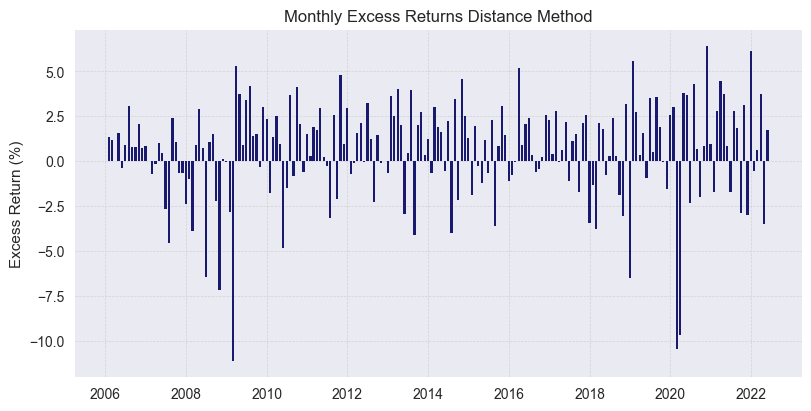

In [22]:
plot_monthly_excess(
    df_distance_grouped_month,
    'Monthly Excess Returns Distance Method',
    out_path=None,
)


(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': 'Monthly Excess Returns Copula Method'}, ylabel='Excess Return (%)'>)

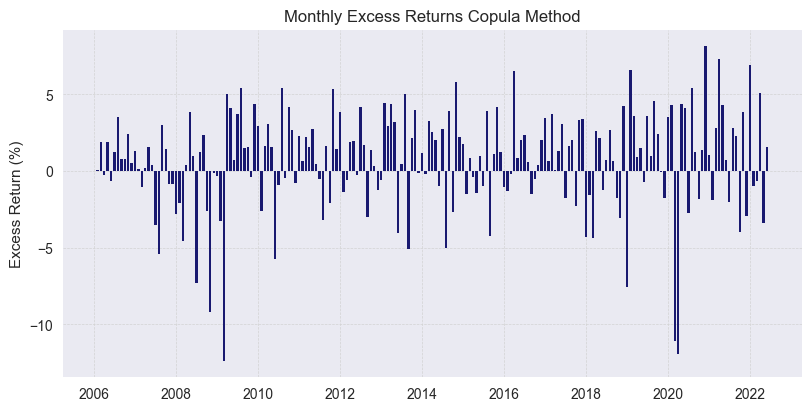

In [23]:
plot_monthly_excess(
    df_copula_grouped_month,
    'Monthly Excess Returns Copula Method',
    out_path=None,
)


In [24]:
def plot_cumulative_excess(df_grouped_month, title):
    x = df_grouped_month["month_end"].to_list()
    y_ec = df_grouped_month["R_EC"].to_numpy().cumsum()
    y_cc = df_grouped_month["R_CC"].to_numpy().cumsum()

    fig, ax = plt.subplots(figsize=(8, 3.5), layout='constrained')
    ax.plot(x, y_ec, label='Employed Capital', color='midnightblue', linewidth=1)
    ax.plot(x, y_cc, label='Committed Capital', color='red', linewidth=1)
    ax.set_title(title)
    ax.grid(which='major', color='lightgrey', linestyle='--', linewidth=0.5)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=False, shadow=False, ncol=2)
    return fig, ax


(<Figure size 800x350 with 1 Axes>,
 <Axes: title={'center': 'Cumulative Excess Return Distance Method'}>)

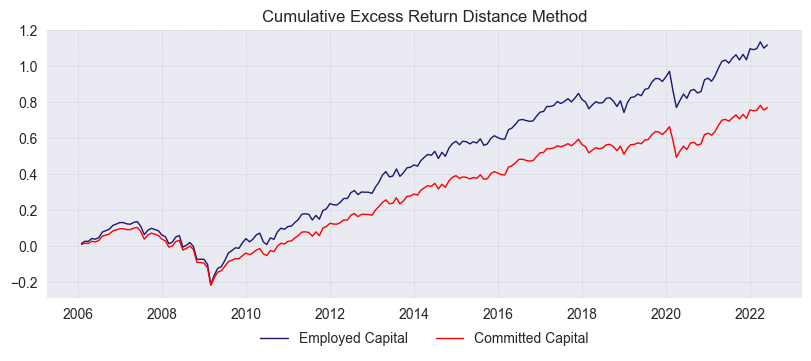

In [25]:
plot_cumulative_excess(
    df_distance_grouped_month,
    'Cumulative Excess Return Distance Method',
)


(<Figure size 800x350 with 1 Axes>,
 <Axes: title={'center': 'Cumulative Excess Return Copula Method'}>)

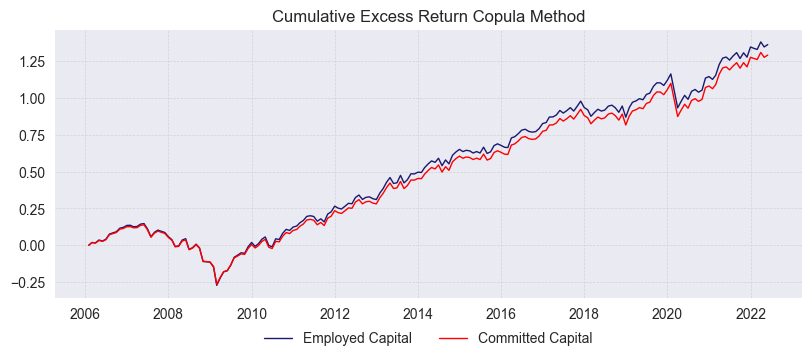

In [26]:
plot_cumulative_excess(
    df_copula_grouped_month,
    'Cumulative Excess Return Copula Method',
)


In [27]:
def plot_trade_returns(df_trades, title, bins=50):
    returns = df_trades["return_total"].to_numpy()
    fig, ax = plt.subplots(figsize=(4, 4), layout='constrained')
    ax.hist(returns, bins=bins, color='midnightblue')
    ax.set_xlabel('Trade Return')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.grid(which='major', color='lightgrey', linestyle='--', linewidth=0.5)
    return fig, ax


(<Figure size 400x400 with 1 Axes>,
 <Axes: title={'center': 'Distance'}, xlabel='Trade Return', ylabel='Frequency'>)

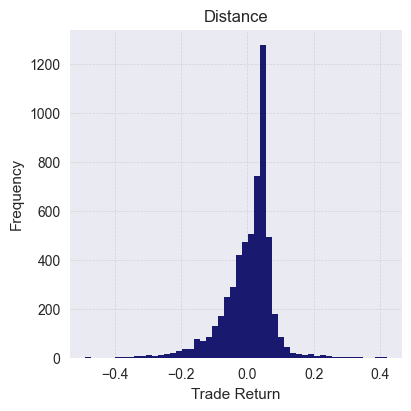

In [28]:
plot_trade_returns(df_distance_trades, 'Distance', bins=50)


(<Figure size 400x400 with 1 Axes>,
 <Axes: title={'center': 'Copula'}, xlabel='Trade Return', ylabel='Frequency'>)

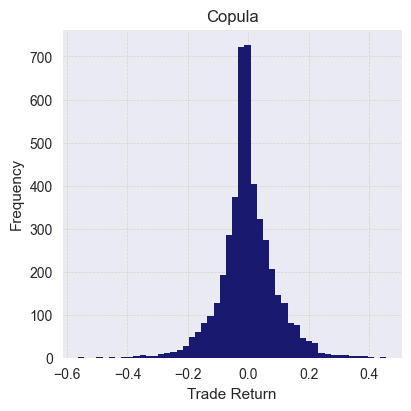

In [29]:
plot_trade_returns(df_copula_trades, 'Copula', bins=50)


In [30]:
import numpy as np
import pyvinecopulib as pv


In [31]:
def _fit_best_marginal(data):
    candidates = [stats.t, stats.norm, stats.genlogistic, stats.genextreme]
    best_aic = np.inf
    best_dist = None

    for dist in candidates:
        try:
            params = dist.fit(data)
            dist_fit = dist(*params)
            log_pdf = np.log(dist_fit.pdf(data) + 1e-12)
            log_like = float(np.sum(log_pdf))
            aic = 2 * len(params) - 2 * log_like
        except Exception:
            continue

        if aic < best_aic:
            best_aic = aic
            best_dist = dist_fit

    if best_dist is None:
        raise RuntimeError('No marginal fit')

    return best_dist


In [32]:
def plot_distance_pair(pair_id):
    con = duckdb.connect(duckdb_path)
    pair = con.execute("SELECT * FROM pair_selection WHERE pair_id = ?", [pair_id]).pl()
    if pair.height == 0:
        con.close()
        raise ValueError('pair_id not found')

    row = pair.row(0)
    period_id = row[pair.columns.index('period_id')]
    stock1 = row[pair.columns.index('stock1')]
    stock2 = row[pair.columns.index('stock2')]
    std = float(row[pair.columns.index('std')])

    period = con.execute("SELECT * FROM periods WHERE id = ?", [period_id]).pl().row(0)
    period_cols = con.execute("SELECT * FROM periods LIMIT 1").pl().columns
    period_map = dict(zip(period_cols, period))

    trading_start = period_map['trading_start']
    trading_end = period_map['trading_end']

    df = con.execute(
        f"SELECT date, \"{stock1}\" AS s1, \"{stock2}\" AS s2 FROM prices_wide WHERE date BETWEEN '{trading_start}' AND '{trading_end}' ORDER BY date"
    ).pl()

    trades = con.execute("SELECT trade_start, trade_end FROM distance_trades WHERE pair_id = ? ORDER BY trade", [pair_id]).pl()
    con.close()

    dates = df['date'].to_list()
    prices = df[['s1', 's2']].to_numpy()
    daily_returns = (prices[1:] - prices[:-1]) / prices[:-1]
    daily_returns = np.vstack([np.zeros((1, 2)), daily_returns])
    cumret = np.cumsum(daily_returns, axis=0)
    spread = cumret[:, 0] - cumret[:, 1]

    fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')
    ax.plot(dates, cumret[:, 0], label=stock1, color='midnightblue', linewidth=1)
    ax.plot(dates, cumret[:, 1], label=stock2, color='mediumblue', linewidth=1)
    ax.plot(dates, spread, label='Spread', color='red', linewidth=1)
    ax.axhline(y=2 * std, color='grey', linestyle='-.', linewidth=1)
    ax.axhline(y=-2 * std, color='grey', linestyle='-.', linewidth=1)

    for t_start, t_end in trades.iter_rows():
        ax.axvspan(t_start, t_end, alpha=0.2, color='grey')

    ax.grid(which='major', color='lightgrey', linestyle='--', linewidth=0.5)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=False, shadow=False, ncol=3)
    ax.set_title(f'Distance Method: {stock1} vs {stock2} (pair_id={pair_id})')
    return fig, ax


In [33]:
def plot_copula_pair(pair_id):
    con = duckdb.connect(duckdb_path)
    pair = con.execute("SELECT * FROM pair_selection WHERE pair_id = ?", [pair_id]).pl()
    if pair.height == 0:
        con.close()
        raise ValueError('pair_id not found')

    row = pair.row(0)
    period_id = row[pair.columns.index('period_id')]
    stock1 = row[pair.columns.index('stock1')]
    stock2 = row[pair.columns.index('stock2')]

    period = con.execute("SELECT * FROM periods WHERE id = ?", [period_id]).pl().row(0)
    period_cols = con.execute("SELECT * FROM periods LIMIT 1").pl().columns
    period_map = dict(zip(period_cols, period))

    formation_start = period_map['formation_start']
    formation_end = period_map['formation_end']
    trading_start = period_map['trading_start']
    trading_end = period_map['trading_end']

    df = con.execute(
        f"SELECT date, \"{stock1}\" AS s1, \"{stock2}\" AS s2 FROM prices_wide WHERE date BETWEEN '{formation_start}' AND '{trading_end}' ORDER BY date"
    ).pl()

    trades = con.execute("SELECT trade_start, trade_end FROM copula_trades WHERE pair_id = ? ORDER BY trade", [pair_id]).pl()
    con.close()

    dates = df['date'].to_list()
    prices = df[['s1', 's2']].to_numpy()
    daily_returns = (prices[1:] - prices[:-1]) / prices[:-1]
    daily_returns = np.vstack([np.zeros((1, 2)), daily_returns])

    date_arr = np.array(dates, dtype='datetime64[D]')
    formation_mask = (date_arr >= np.datetime64(formation_start)) & (date_arr <= np.datetime64(formation_end))
    trading_mask = (date_arr >= np.datetime64(trading_start)) & (date_arr <= np.datetime64(trading_end))

    ret_f = daily_returns[formation_mask]
    ret_t = daily_returns[trading_mask]
    dates_t = [d for d, m in zip(dates, trading_mask) if m]

    dist1 = _fit_best_marginal(ret_f[:, 0])
    dist2 = _fit_best_marginal(ret_f[:, 1])

    s1_cdf_f = np.clip(dist1.cdf(ret_f[:, 0]), 1e-6, 1 - 1e-6)
    s2_cdf_f = np.clip(dist2.cdf(ret_f[:, 1]), 1e-6, 1 - 1e-6)
    s1_cdf_t = np.clip(dist1.cdf(ret_t[:, 0]), 1e-6, 1 - 1e-6)
    s2_cdf_t = np.clip(dist2.cdf(ret_t[:, 1]), 1e-6, 1 - 1e-6)

    data_f = np.column_stack([s1_cdf_f, s2_cdf_f])
    data_t = np.column_stack([s1_cdf_t, s2_cdf_t])

    controls = pv.FitControlsBicop(
        family_set=[pv.BicopFamily.student, pv.BicopFamily.clayton, pv.BicopFamily.gumbel],
        parametric_method='mle',
        selection_criterion='aic',
    )
    cop = pv.Bicop()
    cop.select(data=data_f, controls=controls)

    hfunc1 = cop.hfunc1(data_t)
    hfunc2 = cop.hfunc2(data_t)

    m1 = hfunc1 - 0.5
    m2 = hfunc2 - 0.5
    M1 = np.cumsum(m1)
    M2 = np.cumsum(m2)

    fig1, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
    ax1.plot(dates_t, M1, label=stock1, color='midnightblue', linewidth=1)
    ax1.plot(dates_t, M2, label=stock2, color='mediumblue', linewidth=1)
    ax1.axhline(y=0.5, color='grey', linestyle='-.', linewidth=1)
    ax1.axhline(y=-0.5, color='grey', linestyle='-.', linewidth=1)
    for t_start, t_end in trades.iter_rows():
        ax1.axvspan(t_start, t_end, alpha=0.2, color='grey')
    ax1.grid(which='major', color='lightgrey', linestyle='--', linewidth=0.5)
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=False, shadow=False, ncol=2)
    ax1.set_title(f'Copula Mispricing Indices: {stock1} vs {stock2} (pair_id={pair_id})')

    cumret_t = np.cumsum(ret_t, axis=0)
    fig2, ax2 = plt.subplots(figsize=(8, 4.5), layout='constrained')
    ax2.plot(dates_t, cumret_t[:, 0], label=stock1, color='midnightblue', linewidth=1)
    ax2.plot(dates_t, cumret_t[:, 1], label=stock2, color='mediumblue', linewidth=1)
    for t_start, t_end in trades.iter_rows():
        ax2.axvspan(t_start, t_end, alpha=0.2, color='grey')
    ax2.grid(which='major', color='lightgrey', linestyle='--', linewidth=0.5)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=False, shadow=False, ncol=2)
    ax2.set_title(f'Copula Trading CumReturns: {stock1} vs {stock2} (pair_id={pair_id})')

    return (fig1, ax1), (fig2, ax2)


(<Figure size 800x450 with 1 Axes>,
 <Axes: title={'center': 'Distance Method: WFC vs WAFD (pair_id=0)'}>)

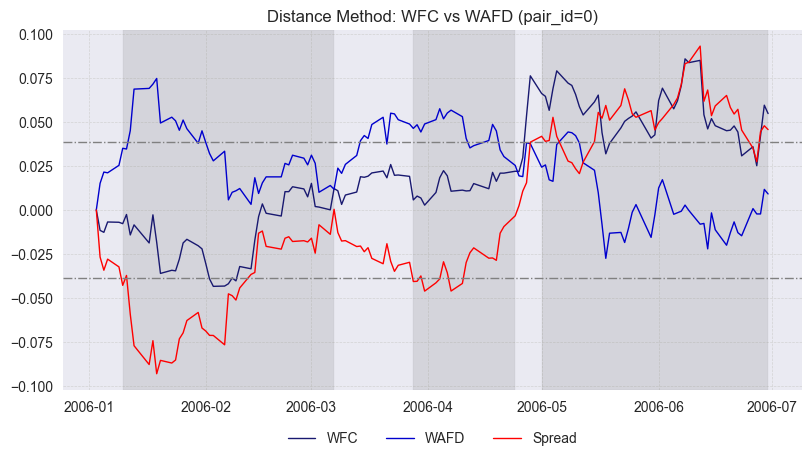

In [34]:
# Example usage
plot_distance_pair(pair_id=0)


((<Figure size 800x450 with 1 Axes>,
  <Axes: title={'center': 'Copula Mispricing Indices: WFC vs WAFD (pair_id=0)'}>),
 (<Figure size 800x450 with 1 Axes>,
  <Axes: title={'center': 'Copula Trading CumReturns: WFC vs WAFD (pair_id=0)'}>))

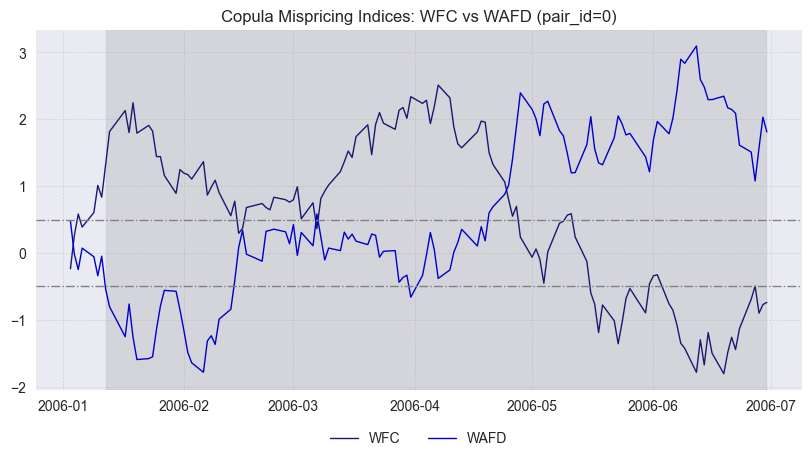

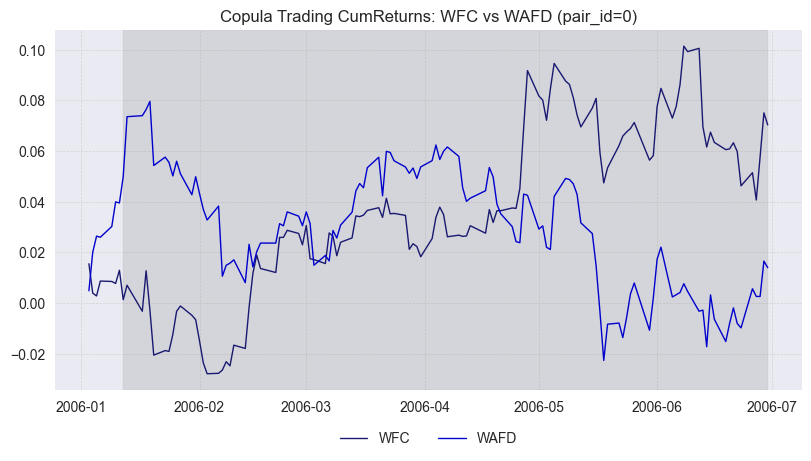

In [35]:
# Example usage
plot_copula_pair(pair_id=0)


In [36]:
def plot_copula_diagnostics(pair_id):
    con = duckdb.connect(duckdb_path)
    pair = con.execute("SELECT * FROM pair_selection WHERE pair_id = ?", [pair_id]).pl()
    if pair.height == 0:
        con.close()
        raise ValueError('pair_id not found')

    row = pair.row(0)
    period_id = row[pair.columns.index('period_id')]
    stock1 = row[pair.columns.index('stock1')]
    stock2 = row[pair.columns.index('stock2')]

    period = con.execute("SELECT * FROM periods WHERE id = ?", [period_id]).pl().row(0)
    period_cols = con.execute("SELECT * FROM periods LIMIT 1").pl().columns
    period_map = dict(zip(period_cols, period))

    formation_start = period_map['formation_start']
    formation_end = period_map['formation_end']
    trading_start = period_map['trading_start']
    trading_end = period_map['trading_end']

    df = con.execute(
        f"SELECT date, \"{stock1}\" AS s1, \"{stock2}\" AS s2 FROM prices_wide WHERE date BETWEEN '{formation_start}' AND '{trading_end}' ORDER BY date"
    ).pl()

    con.close()

    dates = df['date'].to_list()
    prices = df[['s1', 's2']].to_numpy()
    daily_returns = (prices[1:] - prices[:-1]) / prices[:-1]
    daily_returns = np.vstack([np.zeros((1, 2)), daily_returns])

    date_arr = np.array(dates, dtype='datetime64[D]')
    formation_mask = (date_arr >= np.datetime64(formation_start)) & (date_arr <= np.datetime64(formation_end))
    trading_mask = (date_arr >= np.datetime64(trading_start)) & (date_arr <= np.datetime64(trading_end))

    ret_f = daily_returns[formation_mask]
    ret_t = daily_returns[trading_mask]

    dist1 = _fit_best_marginal(ret_f[:, 0])
    dist2 = _fit_best_marginal(ret_f[:, 1])

    s1_cdf_f = np.clip(dist1.cdf(ret_f[:, 0]), 1e-6, 1 - 1e-6)
    s2_cdf_f = np.clip(dist2.cdf(ret_f[:, 1]), 1e-6, 1 - 1e-6)
    s1_cdf_t = np.clip(dist1.cdf(ret_t[:, 0]), 1e-6, 1 - 1e-6)
    s2_cdf_t = np.clip(dist2.cdf(ret_t[:, 1]), 1e-6, 1 - 1e-6)

    data_f = np.column_stack([s1_cdf_f, s2_cdf_f])

    controls = pv.FitControlsBicop(
        family_set=[pv.BicopFamily.student, pv.BicopFamily.clayton, pv.BicopFamily.gumbel],
        parametric_method='mle',
        selection_criterion='aic',
    )
    cop_best = pv.Bicop()
    cop_best.select(data=data_f, controls=controls)

    cop_student = pv.Bicop()
    cop_student.select(data=data_f, controls=pv.FitControlsBicop(family_set=[pv.BicopFamily.student], parametric_method='mle'))
    cop_gumbel = pv.Bicop()
    cop_gumbel.select(data=data_f, controls=pv.FitControlsBicop(family_set=[pv.BicopFamily.gumbel], parametric_method='mle'))
    cop_clayton = pv.Bicop()
    cop_clayton.select(data=data_f, controls=pv.FitControlsBicop(family_set=[pv.BicopFamily.clayton], parametric_method='mle'))

    sim_student = cop_student.simulate(ret_f.shape[0])
    sim_gumbel = cop_gumbel.simulate(ret_f.shape[0])
    sim_clayton = cop_clayton.simulate(ret_f.shape[0])

    fig1, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8, 6), layout='constrained')
    axs[0, 0].scatter(s1_cdf_f, s2_cdf_f, color='midnightblue', s=10)
    axs[0, 0].set_title('(a) Real Data')
    axs[0, 1].scatter(sim_student[:, 0], sim_student[:, 1], color='midnightblue', s=10)
    axs[0, 1].set_title('(b) Student-t')
    axs[1, 0].scatter(sim_clayton[:, 0], sim_clayton[:, 1], color='midnightblue', s=10)
    axs[1, 0].set_title('(c) Clayton')
    axs[1, 1].scatter(sim_gumbel[:, 0], sim_gumbel[:, 1], color='midnightblue', s=10)
    axs[1, 1].set_title('(d) Gumbel')
    for ax in axs.flat:
        ax.set(xlabel=stock1, ylabel=stock2)
        ax.label_outer()

    fig2, axs2 = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(8, 3.25), layout='constrained')
    axs2[0].scatter(s1_cdf_t, s2_cdf_t, color='midnightblue', s=10)
    axs2[0].set_title('(a) Real Data')
    sim_trading = cop_best.simulate(ret_t.shape[0])
    axs2[1].scatter(sim_trading[:, 0], sim_trading[:, 1], color='midnightblue', s=10)
    axs2[1].set_title('(b) Simulated Data')
    for ax in axs2.flat:
        ax.set(xlabel=stock1, ylabel=stock2)
        ax.label_outer()

    fig3, ax3 = plt.subplots(figsize=(6, 4), layout='constrained')
    ax3.scatter(s1_cdf_t, s2_cdf_t, label='Real Data', color='midnightblue', s=10)
    ax3.scatter(sim_trading[:, 0], sim_trading[:, 1], label='Simulated Data', color='red', s=10)
    ax3.legend()
    ax3.set(xlabel=stock1, ylabel=stock2)

    return (fig1, axs), (fig2, axs2), (fig3, ax3)


((<Figure size 800x600 with 4 Axes>,
  array([[<Axes: title={'center': '(a) Real Data'}, ylabel='WAFD'>,
          <Axes: title={'center': '(b) Student-t'}>],
         [<Axes: title={'center': '(c) Clayton'}, xlabel='WFC', ylabel='WAFD'>,
          <Axes: title={'center': '(d) Gumbel'}, xlabel='WFC'>]],
        dtype=object)),
 (<Figure size 800x325 with 2 Axes>,
  array([<Axes: title={'center': '(a) Real Data'}, xlabel='WFC', ylabel='WAFD'>,
         <Axes: title={'center': '(b) Simulated Data'}, xlabel='WFC'>],
        dtype=object)),
 (<Figure size 600x400 with 1 Axes>, <Axes: xlabel='WFC', ylabel='WAFD'>))

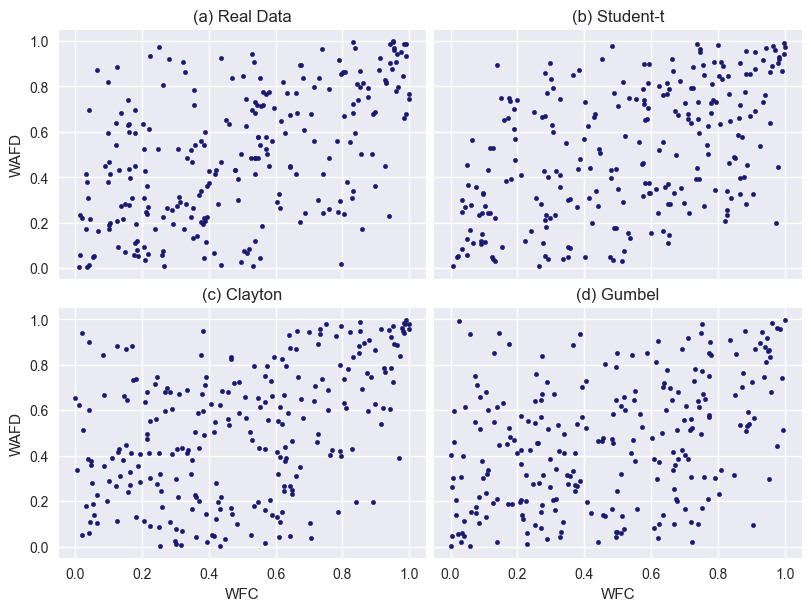

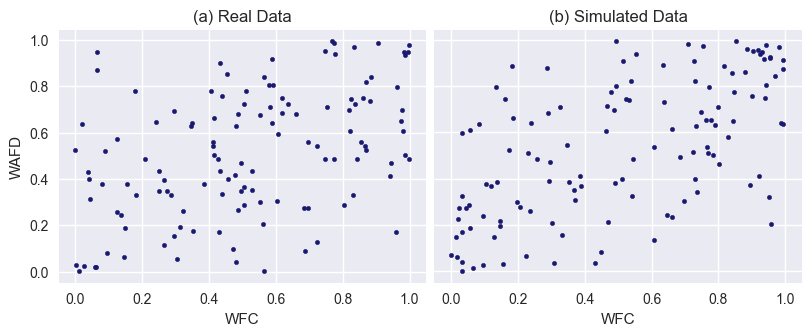

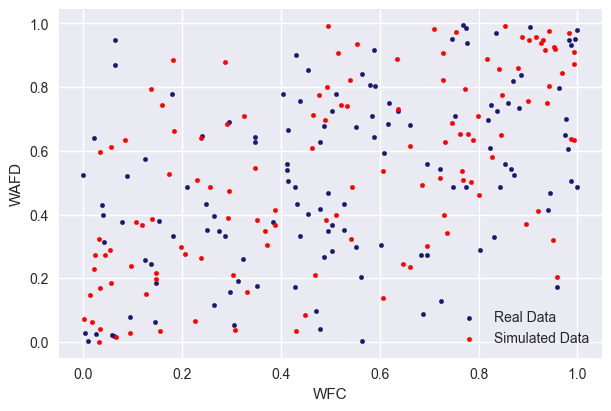

In [37]:
# Example usage
plot_copula_diagnostics(pair_id=0)


In [38]:
from pathlib import Path

results_path = Path("../results")
results_path.mkdir(parents=True, exist_ok=True)
print(f"✅ Results will be saved to: {results_path.resolve()}")


✅ Results will be saved to: /Users/timwinkler/projects/pt-codex/pairs-trading/results


In [39]:
def plot_monthly_excess(df_grouped_month, title, out_path=None):
    x = df_grouped_month["month_end"].to_list()
    y = (df_grouped_month["R_EC"] * 100).to_numpy()

    fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
    ax.bar(x, y, width=20, align='center', color='midnightblue')
    ax.set_title(title)
    ax.set_ylabel('Excess Return (%)')
    ax.grid(which='major', color='lightgrey', linestyle='--', linewidth=0.5)
    if out_path:
        fig.savefig(out_path)
    return fig, ax


In [40]:
def plot_cumulative_excess(df_grouped_month, title, out_path=None):
    x = df_grouped_month["month_end"].to_list()
    y_ec = df_grouped_month["R_EC"].to_numpy().cumsum()
    y_cc = df_grouped_month["R_CC"].to_numpy().cumsum()

    fig, ax = plt.subplots(figsize=(8, 3.5), layout='constrained')
    ax.plot(x, y_ec, label='Employed Capital', color='midnightblue', linewidth=1)
    ax.plot(x, y_cc, label='Committed Capital', color='red', linewidth=1)
    ax.set_title(title)
    ax.grid(which='major', color='lightgrey', linestyle='--', linewidth=0.5)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=False, shadow=False, ncol=2)
    if out_path:
        fig.savefig(out_path)
    return fig, ax


In [41]:
def plot_trade_returns(df_trades, title, bins=50, out_path=None):
    returns = df_trades["return_total"].to_numpy()
    fig, ax = plt.subplots(figsize=(4, 4), layout='constrained')
    ax.hist(returns, bins=bins, color='midnightblue')
    ax.set_xlabel('Trade Return')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.grid(which='major', color='lightgrey', linestyle='--', linewidth=0.5)
    if out_path:
        fig.savefig(out_path)
    return fig, ax


(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': 'Monthly Excess Returns Copula Method'}, ylabel='Excess Return (%)'>)

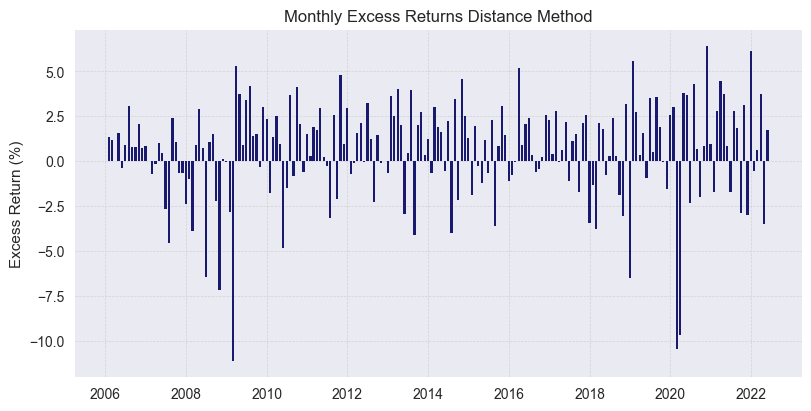

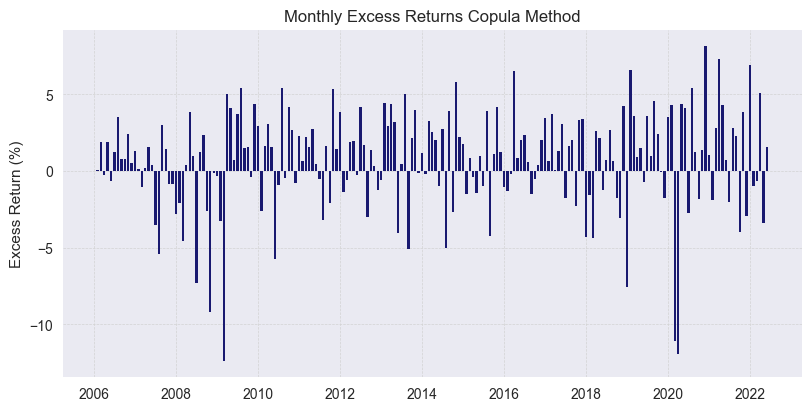

In [42]:
plot_monthly_excess(
    df_distance_grouped_month,
    'Monthly Excess Returns Distance Method',
    out_path=results_path / 'distance_monthly_excess_returns.pdf',
)
plot_monthly_excess(
    df_copula_grouped_month,
    'Monthly Excess Returns Copula Method',
    out_path=results_path / 'copula_monthly_excess_returns.pdf',
)


(<Figure size 800x350 with 1 Axes>,
 <Axes: title={'center': 'Cumulative Excess Return Copula Method'}>)

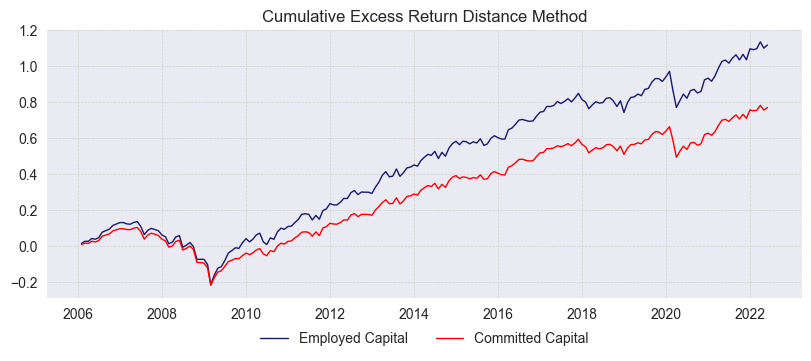

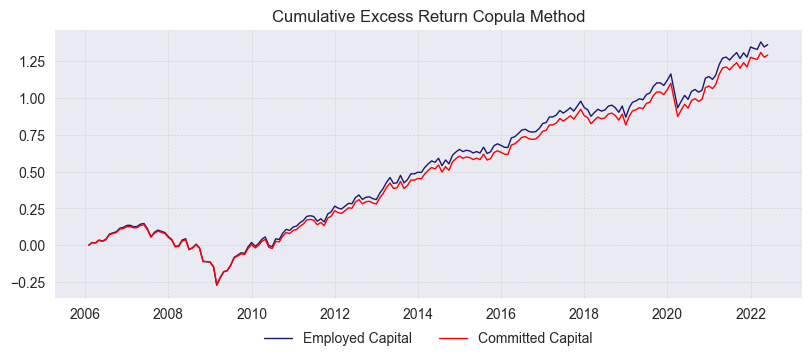

In [43]:
plot_cumulative_excess(
    df_distance_grouped_month,
    'Cumulative Excess Return Distance Method',
    out_path=results_path / 'distance_cumulative_excess_returns.pdf',
)
plot_cumulative_excess(
    df_copula_grouped_month,
    'Cumulative Excess Return Copula Method',
    out_path=results_path / 'copula_cumulative_excess_returns.pdf',
)


(<Figure size 400x400 with 1 Axes>,
 <Axes: title={'center': 'Copula'}, xlabel='Trade Return', ylabel='Frequency'>)

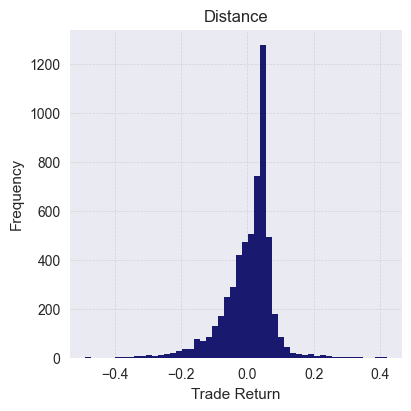

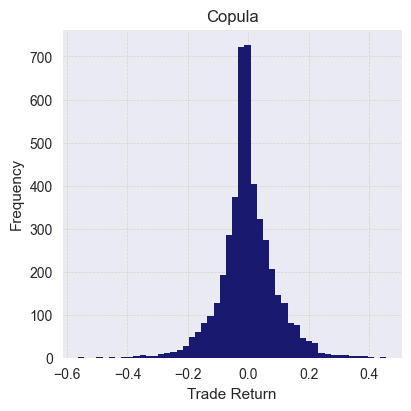

In [44]:
plot_trade_returns(
    df_distance_trades,
    'Distance',
    bins=50,
    out_path=results_path / 'distance_return_distribution.pdf',
)
plot_trade_returns(
    df_copula_trades,
    'Copula',
    bins=50,
    out_path=results_path / 'copula_return_distribution.pdf',
)


In [45]:
def plot_distance_pair(pair_id, out_path=None):
    con = duckdb.connect(duckdb_path)
    pair = con.execute("SELECT * FROM pair_selection WHERE pair_id = ?", [pair_id]).pl()
    if pair.height == 0:
        con.close()
        raise ValueError('pair_id not found')

    row = pair.row(0)
    period_id = row[pair.columns.index('period_id')]
    stock1 = row[pair.columns.index('stock1')]
    stock2 = row[pair.columns.index('stock2')]
    std = float(row[pair.columns.index('std')])

    period = con.execute("SELECT * FROM periods WHERE id = ?", [period_id]).pl().row(0)
    period_cols = con.execute("SELECT * FROM periods LIMIT 1").pl().columns
    period_map = dict(zip(period_cols, period))

    trading_start = period_map['trading_start']
    trading_end = period_map['trading_end']

    df = con.execute(
        f"SELECT date, \"{stock1}\" AS s1, \"{stock2}\" AS s2 FROM prices_wide WHERE date BETWEEN '{trading_start}' AND '{trading_end}' ORDER BY date"
    ).pl()

    trades = con.execute("SELECT trade_start, trade_end FROM distance_trades WHERE pair_id = ? ORDER BY trade", [pair_id]).pl()
    con.close()

    dates = df['date'].to_list()
    prices = df[['s1', 's2']].to_numpy()
    daily_returns = (prices[1:] - prices[:-1]) / prices[:-1]
    daily_returns = np.vstack([np.zeros((1, 2)), daily_returns])
    cumret = np.cumsum(daily_returns, axis=0)
    spread = cumret[:, 0] - cumret[:, 1]

    fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')
    ax.plot(dates, cumret[:, 0], label=stock1, color='midnightblue', linewidth=1)
    ax.plot(dates, cumret[:, 1], label=stock2, color='mediumblue', linewidth=1)
    ax.plot(dates, spread, label='Spread', color='red', linewidth=1)
    ax.axhline(y=2 * std, color='grey', linestyle='-.', linewidth=1)
    ax.axhline(y=-2 * std, color='grey', linestyle='-.', linewidth=1)

    for t_start, t_end in trades.iter_rows():
        ax.axvspan(t_start, t_end, alpha=0.2, color='grey')

    ax.grid(which='major', color='lightgrey', linestyle='--', linewidth=0.5)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=False, shadow=False, ncol=3)
    ax.set_title(f'Distance Method: {stock1} vs {stock2} (pair_id={pair_id})')
    if out_path:
        fig.savefig(out_path, dpi=600)
    return fig, ax


In [46]:
def plot_copula_pair(pair_id, out_paths=None):
    con = duckdb.connect(duckdb_path)
    pair = con.execute("SELECT * FROM pair_selection WHERE pair_id = ?", [pair_id]).pl()
    if pair.height == 0:
        con.close()
        raise ValueError('pair_id not found')

    row = pair.row(0)
    period_id = row[pair.columns.index('period_id')]
    stock1 = row[pair.columns.index('stock1')]
    stock2 = row[pair.columns.index('stock2')]

    period = con.execute("SELECT * FROM periods WHERE id = ?", [period_id]).pl().row(0)
    period_cols = con.execute("SELECT * FROM periods LIMIT 1").pl().columns
    period_map = dict(zip(period_cols, period))

    formation_start = period_map['formation_start']
    formation_end = period_map['formation_end']
    trading_start = period_map['trading_start']
    trading_end = period_map['trading_end']

    df = con.execute(
        f"SELECT date, \"{stock1}\" AS s1, \"{stock2}\" AS s2 FROM prices_wide WHERE date BETWEEN '{formation_start}' AND '{trading_end}' ORDER BY date"
    ).pl()

    trades = con.execute("SELECT trade_start, trade_end FROM copula_trades WHERE pair_id = ? ORDER BY trade", [pair_id]).pl()
    con.close()

    dates = df['date'].to_list()
    prices = df[['s1', 's2']].to_numpy()
    daily_returns = (prices[1:] - prices[:-1]) / prices[:-1]
    daily_returns = np.vstack([np.zeros((1, 2)), daily_returns])

    date_arr = np.array(dates, dtype='datetime64[D]')
    formation_mask = (date_arr >= np.datetime64(formation_start)) & (date_arr <= np.datetime64(formation_end))
    trading_mask = (date_arr >= np.datetime64(trading_start)) & (date_arr <= np.datetime64(trading_end))

    ret_f = daily_returns[formation_mask]
    ret_t = daily_returns[trading_mask]
    dates_t = [d for d, m in zip(dates, trading_mask) if m]

    dist1 = _fit_best_marginal(ret_f[:, 0])
    dist2 = _fit_best_marginal(ret_f[:, 1])

    s1_cdf_f = np.clip(dist1.cdf(ret_f[:, 0]), 1e-6, 1 - 1e-6)
    s2_cdf_f = np.clip(dist2.cdf(ret_f[:, 1]), 1e-6, 1 - 1e-6)
    s1_cdf_t = np.clip(dist1.cdf(ret_t[:, 0]), 1e-6, 1 - 1e-6)
    s2_cdf_t = np.clip(dist2.cdf(ret_t[:, 1]), 1e-6, 1 - 1e-6)

    data_f = np.column_stack([s1_cdf_f, s2_cdf_f])
    data_t = np.column_stack([s1_cdf_t, s2_cdf_t])

    controls = pv.FitControlsBicop(
        family_set=[pv.BicopFamily.student, pv.BicopFamily.clayton, pv.BicopFamily.gumbel],
        parametric_method='mle',
        selection_criterion='aic',
    )
    cop = pv.Bicop()
    cop.select(data=data_f, controls=controls)

    hfunc1 = cop.hfunc1(data_t)
    hfunc2 = cop.hfunc2(data_t)

    m1 = hfunc1 - 0.5
    m2 = hfunc2 - 0.5
    M1 = np.cumsum(m1)
    M2 = np.cumsum(m2)

    fig1, ax1 = plt.subplots(figsize=(8, 4.5), layout='constrained')
    ax1.plot(dates_t, M1, label=stock1, color='midnightblue', linewidth=1)
    ax1.plot(dates_t, M2, label=stock2, color='mediumblue', linewidth=1)
    ax1.axhline(y=0.5, color='grey', linestyle='-.', linewidth=1)
    ax1.axhline(y=-0.5, color='grey', linestyle='-.', linewidth=1)
    for t_start, t_end in trades.iter_rows():
        ax1.axvspan(t_start, t_end, alpha=0.2, color='grey')
    ax1.grid(which='major', color='lightgrey', linestyle='--', linewidth=0.5)
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=False, shadow=False, ncol=2)
    ax1.set_title(f'Copula Mispricing Indices: {stock1} vs {stock2} (pair_id={pair_id})')

    cumret_t = np.cumsum(ret_t, axis=0)
    fig2, ax2 = plt.subplots(figsize=(8, 4.5), layout='constrained')
    ax2.plot(dates_t, cumret_t[:, 0], label=stock1, color='midnightblue', linewidth=1)
    ax2.plot(dates_t, cumret_t[:, 1], label=stock2, color='mediumblue', linewidth=1)
    for t_start, t_end in trades.iter_rows():
        ax2.axvspan(t_start, t_end, alpha=0.2, color='grey')
    ax2.grid(which='major', color='lightgrey', linestyle='--', linewidth=0.5)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=False, shadow=False, ncol=2)
    ax2.set_title(f'Copula Trading CumReturns: {stock1} vs {stock2} (pair_id={pair_id})')

    if out_paths:
        if out_paths.get('mispricing'):
            fig1.savefig(out_paths['mispricing'], dpi=600)
        if out_paths.get('cumret'):
            fig2.savefig(out_paths['cumret'], dpi=600)

    return (fig1, ax1), (fig2, ax2)


In [47]:
def plot_copula_diagnostics(pair_id, out_paths=None):
    con = duckdb.connect(duckdb_path)
    pair = con.execute("SELECT * FROM pair_selection WHERE pair_id = ?", [pair_id]).pl()
    if pair.height == 0:
        con.close()
        raise ValueError('pair_id not found')

    row = pair.row(0)
    period_id = row[pair.columns.index('period_id')]
    stock1 = row[pair.columns.index('stock1')]
    stock2 = row[pair.columns.index('stock2')]

    period = con.execute("SELECT * FROM periods WHERE id = ?", [period_id]).pl().row(0)
    period_cols = con.execute("SELECT * FROM periods LIMIT 1").pl().columns
    period_map = dict(zip(period_cols, period))

    formation_start = period_map['formation_start']
    formation_end = period_map['formation_end']
    trading_start = period_map['trading_start']
    trading_end = period_map['trading_end']

    df = con.execute(
        f"SELECT date, \"{stock1}\" AS s1, \"{stock2}\" AS s2 FROM prices_wide WHERE date BETWEEN '{formation_start}' AND '{trading_end}' ORDER BY date"
    ).pl()

    con.close()

    dates = df['date'].to_list()
    prices = df[['s1', 's2']].to_numpy()
    daily_returns = (prices[1:] - prices[:-1]) / prices[:-1]
    daily_returns = np.vstack([np.zeros((1, 2)), daily_returns])

    date_arr = np.array(dates, dtype='datetime64[D]')
    formation_mask = (date_arr >= np.datetime64(formation_start)) & (date_arr <= np.datetime64(formation_end))
    trading_mask = (date_arr >= np.datetime64(trading_start)) & (date_arr <= np.datetime64(trading_end))

    ret_f = daily_returns[formation_mask]
    ret_t = daily_returns[trading_mask]

    dist1 = _fit_best_marginal(ret_f[:, 0])
    dist2 = _fit_best_marginal(ret_f[:, 1])

    s1_cdf_f = np.clip(dist1.cdf(ret_f[:, 0]), 1e-6, 1 - 1e-6)
    s2_cdf_f = np.clip(dist2.cdf(ret_f[:, 1]), 1e-6, 1 - 1e-6)
    s1_cdf_t = np.clip(dist1.cdf(ret_t[:, 0]), 1e-6, 1 - 1e-6)
    s2_cdf_t = np.clip(dist2.cdf(ret_t[:, 1]), 1e-6, 1 - 1e-6)

    data_f = np.column_stack([s1_cdf_f, s2_cdf_f])

    controls = pv.FitControlsBicop(
        family_set=[pv.BicopFamily.student, pv.BicopFamily.clayton, pv.BicopFamily.gumbel],
        parametric_method='mle',
        selection_criterion='aic',
    )
    cop_best = pv.Bicop()
    cop_best.select(data=data_f, controls=controls)

    cop_student = pv.Bicop()
    cop_student.select(data=data_f, controls=pv.FitControlsBicop(family_set=[pv.BicopFamily.student], parametric_method='mle'))
    cop_gumbel = pv.Bicop()
    cop_gumbel.select(data=data_f, controls=pv.FitControlsBicop(family_set=[pv.BicopFamily.gumbel], parametric_method='mle'))
    cop_clayton = pv.Bicop()
    cop_clayton.select(data=data_f, controls=pv.FitControlsBicop(family_set=[pv.BicopFamily.clayton], parametric_method='mle'))

    sim_student = cop_student.simulate(ret_f.shape[0])
    sim_gumbel = cop_gumbel.simulate(ret_f.shape[0])
    sim_clayton = cop_clayton.simulate(ret_f.shape[0])

    fig1, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8, 6), layout='constrained')
    axs[0, 0].scatter(s1_cdf_f, s2_cdf_f, color='midnightblue', s=10)
    axs[0, 0].set_title('(a) Real Data')
    axs[0, 1].scatter(sim_student[:, 0], sim_student[:, 1], color='midnightblue', s=10)
    axs[0, 1].set_title('(b) Student-t')
    axs[1, 0].scatter(sim_clayton[:, 0], sim_clayton[:, 1], color='midnightblue', s=10)
    axs[1, 0].set_title('(c) Clayton')
    axs[1, 1].scatter(sim_gumbel[:, 0], sim_gumbel[:, 1], color='midnightblue', s=10)
    axs[1, 1].set_title('(d) Gumbel')
    for ax in axs.flat:
        ax.set(xlabel=stock1, ylabel=stock2)
        ax.label_outer()

    fig2, axs2 = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(8, 3.25), layout='constrained')
    axs2[0].scatter(s1_cdf_t, s2_cdf_t, color='midnightblue', s=10)
    axs2[0].set_title('(a) Real Data')
    sim_trading = cop_best.simulate(ret_t.shape[0])
    axs2[1].scatter(sim_trading[:, 0], sim_trading[:, 1], color='midnightblue', s=10)
    axs2[1].set_title('(b) Simulated Data')
    for ax in axs2.flat:
        ax.set(xlabel=stock1, ylabel=stock2)
        ax.label_outer()

    fig3, ax3 = plt.subplots(figsize=(6, 4), layout='constrained')
    ax3.scatter(s1_cdf_t, s2_cdf_t, label='Real Data', color='midnightblue', s=10)
    ax3.scatter(sim_trading[:, 0], sim_trading[:, 1], label='Simulated Data', color='red', s=10)
    ax3.legend()
    ax3.set(xlabel=stock1, ylabel=stock2)

    if out_paths:
        if out_paths.get('copula_comp'):
            fig1.savefig(out_paths['copula_comp'])
        if out_paths.get('predictions'):
            fig2.savefig(out_paths['predictions'])
        if out_paths.get('predictions_scatter'):
            fig3.savefig(out_paths['predictions_scatter'])

    return (fig1, axs), (fig2, axs2), (fig3, ax3)


((<Figure size 800x600 with 4 Axes>,
  array([[<Axes: title={'center': '(a) Real Data'}, ylabel='WAFD'>,
          <Axes: title={'center': '(b) Student-t'}>],
         [<Axes: title={'center': '(c) Clayton'}, xlabel='WFC', ylabel='WAFD'>,
          <Axes: title={'center': '(d) Gumbel'}, xlabel='WFC'>]],
        dtype=object)),
 (<Figure size 800x325 with 2 Axes>,
  array([<Axes: title={'center': '(a) Real Data'}, xlabel='WFC', ylabel='WAFD'>,
         <Axes: title={'center': '(b) Simulated Data'}, xlabel='WFC'>],
        dtype=object)),
 (<Figure size 600x400 with 1 Axes>, <Axes: xlabel='WFC', ylabel='WAFD'>))

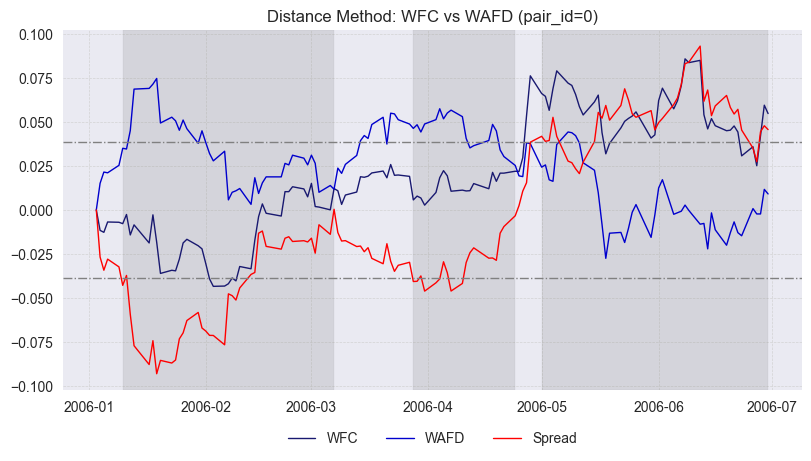

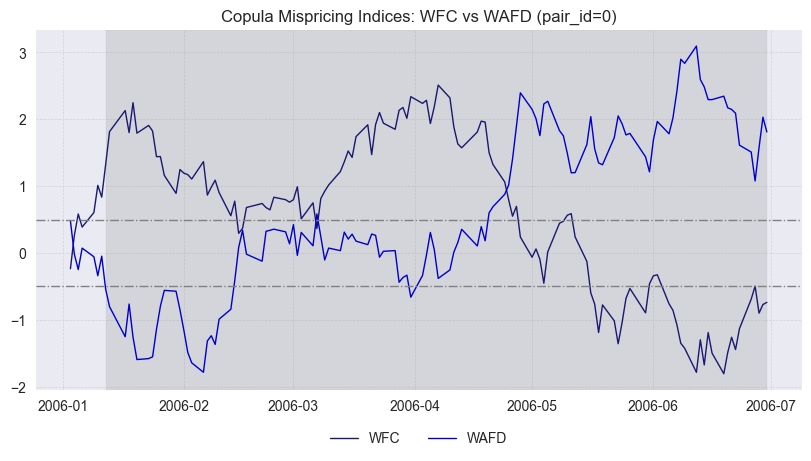

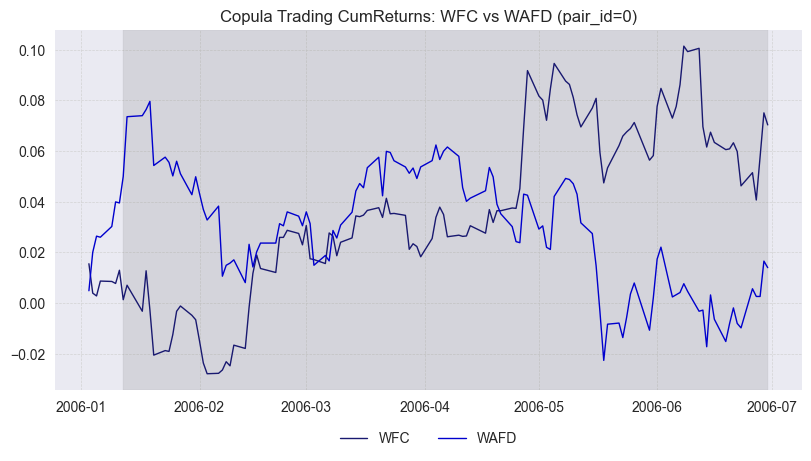

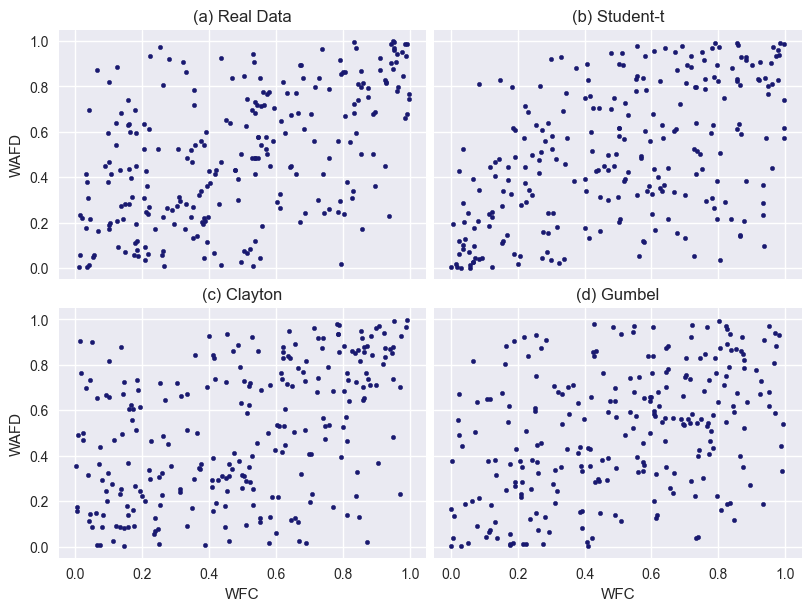

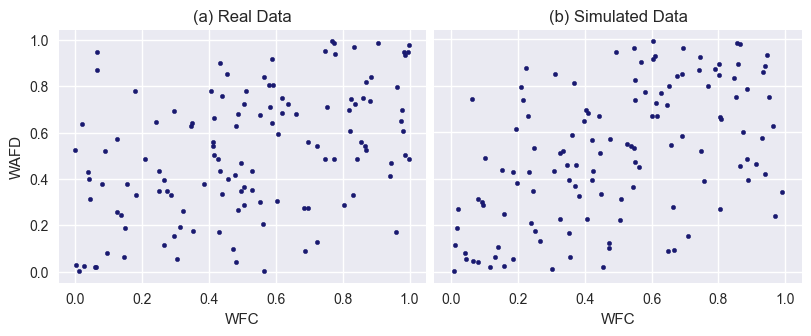

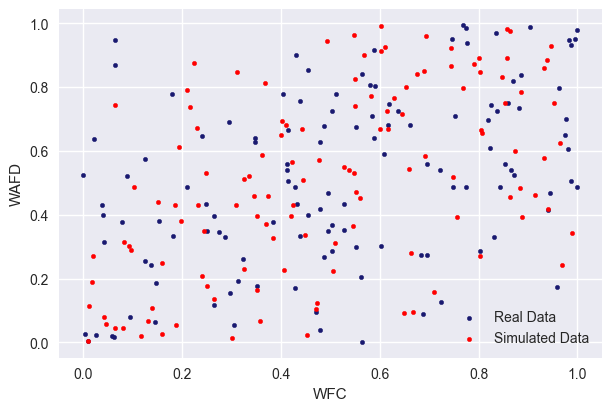

In [48]:
# Example usage
pair_id = 0
plot_distance_pair(
    pair_id=pair_id,
    out_path=results_path / 'distance_methodology.pdf',
)
plot_copula_pair(
    pair_id=pair_id,
    out_paths={
        'mispricing': results_path / 'copula_methodology_mispricing_indices.pdf',
        'cumret': results_path / 'copula_methodology_cumret.pdf',
    },
)
plot_copula_diagnostics(
    pair_id=pair_id,
    out_paths={
        'copula_comp': results_path / 'copula_methodology_copula_comp.pdf',
        'predictions': results_path / 'copula_methodology_predictions_trading.pdf',
        'predictions_scatter': results_path / 'copula_methodology_predictions_trading_scatter.pdf',
    },
)


In [49]:
# Fix: pyvinecopulib Bicop does not accept data/controls in __init__
def plot_copula_diagnostics(pair_id, out_paths=None):
    con = duckdb.connect(duckdb_path)
    pair = con.execute("SELECT * FROM pair_selection WHERE pair_id = ?", [pair_id]).pl()
    if pair.height == 0:
        con.close()
        raise ValueError('pair_id not found')

    row = pair.row(0)
    period_id = row[pair.columns.index('period_id')]
    stock1 = row[pair.columns.index('stock1')]
    stock2 = row[pair.columns.index('stock2')]

    period = con.execute("SELECT * FROM periods WHERE id = ?", [period_id]).pl().row(0)
    period_cols = con.execute("SELECT * FROM periods LIMIT 1").pl().columns
    period_map = dict(zip(period_cols, period))

    formation_start = period_map['formation_start']
    formation_end = period_map['formation_end']
    trading_start = period_map['trading_start']
    trading_end = period_map['trading_end']

    df = con.execute(
        f"SELECT date, \"{stock1}\" AS s1, \"{stock2}\" AS s2 FROM prices_wide WHERE date BETWEEN '{formation_start}' AND '{trading_end}' ORDER BY date"
    ).pl()

    con.close()

    dates = df['date'].to_list()
    prices = df[['s1', 's2']].to_numpy()
    daily_returns = (prices[1:] - prices[:-1]) / prices[:-1]
    daily_returns = np.vstack([np.zeros((1, 2)), daily_returns])

    date_arr = np.array(dates, dtype='datetime64[D]')
    formation_mask = (date_arr >= np.datetime64(formation_start)) & (date_arr <= np.datetime64(formation_end))
    trading_mask = (date_arr >= np.datetime64(trading_start)) & (date_arr <= np.datetime64(trading_end))

    ret_f = daily_returns[formation_mask]
    ret_t = daily_returns[trading_mask]

    dist1 = _fit_best_marginal(ret_f[:, 0])
    dist2 = _fit_best_marginal(ret_f[:, 1])

    s1_cdf_f = np.clip(dist1.cdf(ret_f[:, 0]), 1e-6, 1 - 1e-6)
    s2_cdf_f = np.clip(dist2.cdf(ret_f[:, 1]), 1e-6, 1 - 1e-6)
    s1_cdf_t = np.clip(dist1.cdf(ret_t[:, 0]), 1e-6, 1 - 1e-6)
    s2_cdf_t = np.clip(dist2.cdf(ret_t[:, 1]), 1e-6, 1 - 1e-6)

    data_f = np.column_stack([s1_cdf_f, s2_cdf_f])

    controls = pv.FitControlsBicop(
        family_set=[pv.BicopFamily.student, pv.BicopFamily.clayton, pv.BicopFamily.gumbel],
        parametric_method='mle',
        selection_criterion='aic',
    )
    cop_best = pv.Bicop()
    cop_best.select(data=data_f, controls=controls)

    cop_student = pv.Bicop()
    cop_student.select(data=data_f, controls=pv.FitControlsBicop(family_set=[pv.BicopFamily.student], parametric_method='mle'))
    cop_gumbel = pv.Bicop()
    cop_gumbel.select(data=data_f, controls=pv.FitControlsBicop(family_set=[pv.BicopFamily.gumbel], parametric_method='mle'))
    cop_clayton = pv.Bicop()
    cop_clayton.select(data=data_f, controls=pv.FitControlsBicop(family_set=[pv.BicopFamily.clayton], parametric_method='mle'))

    sim_student = cop_student.simulate(ret_f.shape[0])
    sim_gumbel = cop_gumbel.simulate(ret_f.shape[0])
    sim_clayton = cop_clayton.simulate(ret_f.shape[0])

    fig1, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8, 6), layout='constrained')
    axs[0, 0].scatter(s1_cdf_f, s2_cdf_f, color='midnightblue', s=10)
    axs[0, 0].set_title('(a) Real Data')
    axs[0, 1].scatter(sim_student[:, 0], sim_student[:, 1], color='midnightblue', s=10)
    axs[0, 1].set_title('(b) Student-t')
    axs[1, 0].scatter(sim_clayton[:, 0], sim_clayton[:, 1], color='midnightblue', s=10)
    axs[1, 0].set_title('(c) Clayton')
    axs[1, 1].scatter(sim_gumbel[:, 0], sim_gumbel[:, 1], color='midnightblue', s=10)
    axs[1, 1].set_title('(d) Gumbel')
    for ax in axs.flat:
        ax.set(xlabel=stock1, ylabel=stock2)
        ax.label_outer()

    fig2, axs2 = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(8, 3.25), layout='constrained')
    axs2[0].scatter(s1_cdf_t, s2_cdf_t, color='midnightblue', s=10)
    axs2[0].set_title('(a) Real Data')
    sim_trading = cop_best.simulate(ret_t.shape[0])
    axs2[1].scatter(sim_trading[:, 0], sim_trading[:, 1], color='midnightblue', s=10)
    axs2[1].set_title('(b) Simulated Data')
    for ax in axs2.flat:
        ax.set(xlabel=stock1, ylabel=stock2)
        ax.label_outer()

    fig3, ax3 = plt.subplots(figsize=(6, 4), layout='constrained')
    ax3.scatter(s1_cdf_t, s2_cdf_t, label='Real Data', color='midnightblue', s=10)
    ax3.scatter(sim_trading[:, 0], sim_trading[:, 1], label='Simulated Data', color='red', s=10)
    ax3.legend()
    ax3.set(xlabel=stock1, ylabel=stock2)

    if out_paths:
        if out_paths.get('copula_comp'):
            fig1.savefig(out_paths['copula_comp'])
        if out_paths.get('predictions'):
            fig2.savefig(out_paths['predictions'])
        if out_paths.get('predictions_scatter'):
            fig3.savefig(out_paths['predictions_scatter'])

    return (fig1, axs), (fig2, axs2), (fig3, ax3)


((<Figure size 800x600 with 4 Axes>,
  array([[<Axes: title={'center': '(a) Real Data'}, ylabel='WAFD'>,
          <Axes: title={'center': '(b) Student-t'}>],
         [<Axes: title={'center': '(c) Clayton'}, xlabel='WFC', ylabel='WAFD'>,
          <Axes: title={'center': '(d) Gumbel'}, xlabel='WFC'>]],
        dtype=object)),
 (<Figure size 800x325 with 2 Axes>,
  array([<Axes: title={'center': '(a) Real Data'}, xlabel='WFC', ylabel='WAFD'>,
         <Axes: title={'center': '(b) Simulated Data'}, xlabel='WFC'>],
        dtype=object)),
 (<Figure size 600x400 with 1 Axes>, <Axes: xlabel='WFC', ylabel='WAFD'>))

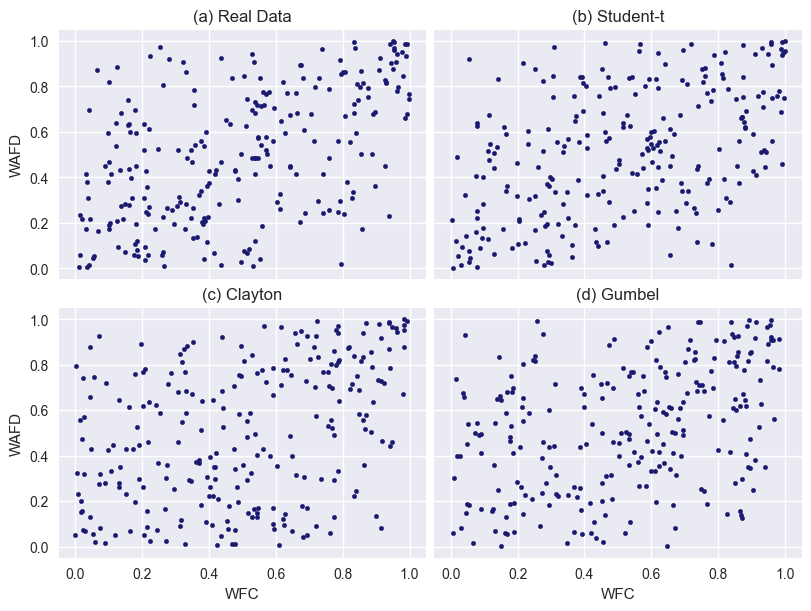

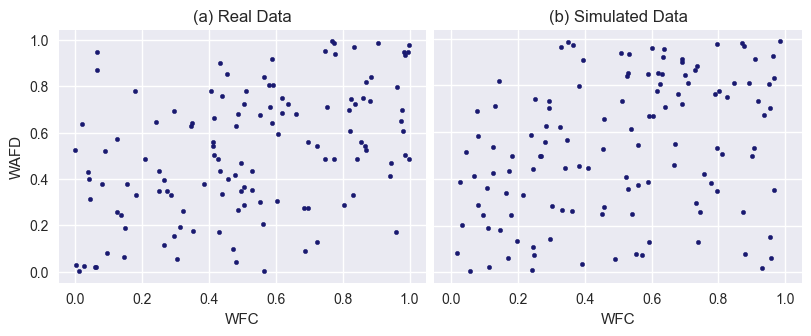

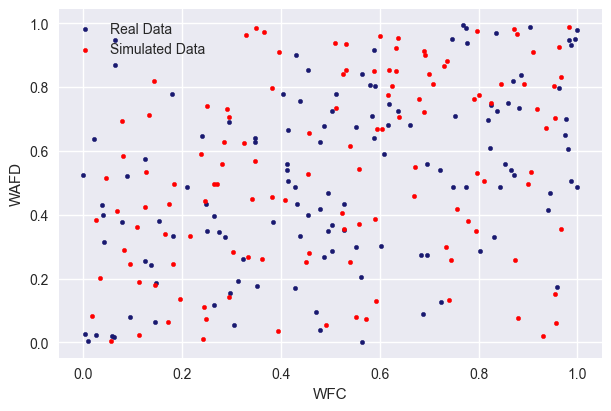

In [50]:
# Example usage
plot_copula_diagnostics(pair_id=0)
